# Import

In [1]:
import csv
import os
import pickle
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

## Add configuration file

In [2]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../PlotFunction/lineplot/")
sys.path.append("../PlotFunction/config/")

In [3]:
from ALL import config
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_1_layout import layout
from util import *

## Set condition

In [4]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [5]:
data_types = ["20News", "AgNews", "AgNewsTitle"]
vectorize_types = ["doc2vec", "sentenceBERT"]

# Read data

In [6]:
model_nums = config["clustering"]["gmm"]["max_model_num"]
covariance_types = config["clustering"]["gmm"]["covariance_types"]

In [16]:
stats_vals = ["aic", "bic", "mi", "logl"]

In [17]:
def load_stats_data(data_type, vectorize_type):
    # データ型定義
    stats = {
        stats_val: {
            covariance_type: {
                model_num: pd.DataFrame for model_num in range(model_nums)
            }
            for covariance_type in covariance_types
        }
        for stats_val in stats_vals
    }

    # データ取得
    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            for model_num in range(model_nums):
                stats_path = f"../../Postprocessing/data/{data_type}/{vectorize_type}/GMM/stats/{covariance_type}/{model_num}.csv"
                df = pd.read_csv(stats_path, index_col=0)
                stats[stats_val][covariance_type][model_num] = df.loc[:, stats_val]
    return stats

In [18]:
def load_lda_mi(data_type):
    lda_mi = pd.read_csv(
        f"../../Postprocessing/data/{data_type}/LDA/mi.csv", index_col=0
    )
    describe_lda_mi, _ = get_describe(lda_mi, axis=0)
    return describe_lda_mi

In [19]:
stats_dict = {
    data_type: {vectorize_type: pd.DataFrame for vectorize_type in vectorize_types}
    for data_type in data_types
}
for data_type in data_types:
    for vectorize_type in vectorize_types:
        stats_dict[data_type][vectorize_type] = load_stats_data(
            data_type,
            vectorize_type,
        )

In [20]:
describe_lda_mi = {}
for data_type in data_types:
    describe_lda_mi[data_type] = load_lda_mi(data_type)

# Data shaping

In [21]:
def shape_stats_df(stats):
    stats_df = {
        stats_val: {
            covariance_type: pd.DataFrame() for covariance_type in covariance_types
        }
        for stats_val in stats_vals
    }

    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            # model_numについて取得データstatsを結合
            stats_df[stats_val][covariance_type] = pd.concat(
                stats[stats_val][covariance_type], axis=1
            )
    return stats_df

In [22]:
def shape_describe(stats_df):
    describe = {
        stats_val: {covariance_type: dict() for covariance_type in covariance_types}
        for stats_val in stats_vals
    }

    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            describe[stats_val][covariance_type], describe_keys = get_describe(
                stats_df[stats_val][covariance_type], axis=1
            )
    return describe, describe_keys

In [23]:
def shape_data(describe, describe_keys):
    data = {
        stats_val: {describe_key: pd.DataFrame() for describe_key in describe_keys}
        for stats_val in stats_vals
    }
    for stats_val in stats_vals:
        for describe_key in describe_keys:
            # covariance_typeについてデータを結合
            _data = {
                covariance_type: describe[stats_val][covariance_type][describe_key]
                for covariance_type in covariance_types
            }
            data[stats_val][describe_key] = pd.concat(_data, axis=1)
    return data

In [37]:
data = {
    data_type: {vectorize_type: {} for vectorize_type in vectorize_types}
    for data_type in data_types
}
for data_type in data_types:
    for vectorize_type, stats in stats_dict[data_type].items():
        stats_df = shape_stats_df(stats)
        describe, describe_keys = shape_describe(stats_df)
        data[data_type][vectorize_type] = shape_data(describe, describe_keys)

# Make Chart

In [38]:
data

{'20News': {'doc2vec': {'aic': {'mean':         spherical          diag          tied          full
    2    1.094506e+03 -2.573838e+04  2.928762e+03 -9.446328e+04
    4    2.439633e+04  6.505122e+03  2.773325e+04 -2.260911e+04
    6    3.129383e+04  1.592660e+04  2.550160e+04 -1.033301e+04
    8    2.591977e+04  1.558826e+04  1.509498e+04 -1.589870e+04
    10   6.805245e+03 -9.983085e+01 -5.396610e+03 -3.531766e+04
    20  -1.899425e+05 -1.964327e+05 -2.146526e+05 -2.495440e+05
    40  -8.155162e+05 -8.205266e+05 -8.617503e+05 -9.118458e+05
    80  -2.541975e+06 -2.546440e+06 -2.626425e+06 -2.685941e+06
    160 -7.004908e+06 -7.009263e+06 -7.202183e+06 -7.190340e+06,
    'median':         spherical          diag          tied          full
    2    9.595681e+02 -2.620622e+04  2.912995e+03 -9.433558e+04
    4    2.442525e+04  6.216825e+03  2.773419e+04 -2.269225e+04
    6    3.131298e+04  1.597821e+04  2.539460e+04 -1.039254e+04
    8    2.585227e+04  1.559412e+04  1.492689e+04 -1.5793

In [56]:
chart_data = {
    vectorize_type: {data_type: {} for data_type in data_types}
    for vectorize_type in vectorize_types
}
for data_type in data_types:
    for vectorize_type, _data in data[data_type].items():
        mi_max_idx = _data["mi"]["mean"].stack().idxmax()
        chart_data[vectorize_type][data_type] = {
            "mutual information": _data["mi"]["mean"].loc[mi_max_idx],
            "分散": _data["mi"]["std"].loc[mi_max_idx],
        }

In [59]:
chart_data["LDA"] = {}
for data_type in data_types:
    chart_data["LDA"][data_type] = {
        "mutual information": describe_lda_mi[data_type]["mean"].to_numpy()[0],
        "分散": describe_lda_mi[data_type]["std"].to_numpy()[0],
    }

In [60]:
chart_data

{'doc2vec': {'20News': {'mutual information': 0.5652929618979637,
   '分散': 0.008690152124701974},
  'AgNews': {'mutual information': 0.47541330783274405,
   '分散': 0.0002217056813169416},
  'AgNewsTitle': {'mutual information': 0.216079607330899,
   '分散': 0.0005672788329092607}},
 'sentenceBERT': {'20News': {'mutual information': 0.6328436557631199,
   '分散': 0.009302632150168468},
  'AgNews': {'mutual information': 0.6149836304614008,
   '分散': 0.01871271467088295},
  'AgNewsTitle': {'mutual information': 0.5200915147894267,
   '分散': 4.230357428712255e-05}},
 'LDA': {'20News': {'mutual information': 0.3321961271457895,
   '分散': 0.01686450822361769},
  'AgNews': {'mutual information': 0.4075657154322703,
   '分散': 0.07254965612659937},
  'AgNewsTitle': {'mutual information': 0.02257982386581941,
   '分散': 0.008628400855017399}}}

In [96]:
xticklabels = data_types
xticks=np.arange(len(data_types))
yticks=np.arange(0, 1.1, 0.1)

xlabel = "データセット"
ylabel = "mutual information"
title = "mutual informationの比較"

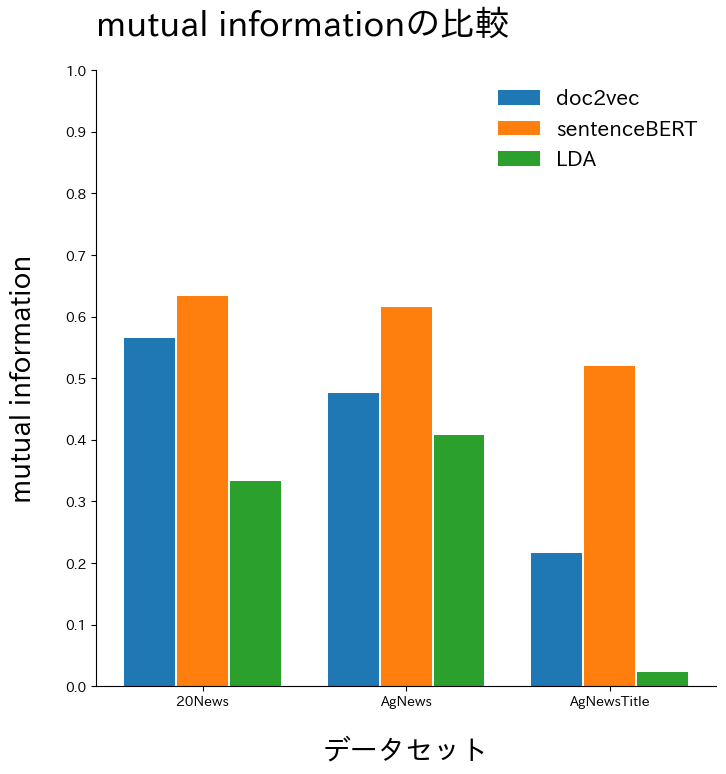

In [108]:
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
fig_path = f"../data/figure/stats_mi.pdf"

x = np.arange(len(chart_data.keys()))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

n = len(vectorize_types)
group_gap = 0.5
bar_gap = 0.01
total_width = 1 - group_gap + n * bar_gap

for i, (vectorize_type, data) in enumerate(chart_data.items()):
    y = [data[data_type]["mutual information"] for data_type in data_types]
    pos = x - total_width * (1 - (2 * i) / n) / 2
    plt.bar(pos, y, width, align="center", label=vectorize_type)

ax.set_title(title, **layout["title"])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel(xlabel, **layout["label"])
ax.set_ylabel(ylabel, **layout["label"])
ax.set_yticks(ticks=yticks, **layout["ticks"])
ax.legend(**layout["legend"])

fig.savefig(make_filepath(fig_path))

# 